 # Проект № 4: Определение перспективного тарифа для телеком-компании

## Описание проекта

Я аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.  

**Задача:** Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Исходные данные:** В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

## Описание тарифов

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   * минута разговора: 3 рубля
   * сообщение: 3 рубля
   * 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   * минута разговора: 1 рубль
   * сообщение: 1 рубль
   * 1 Гб интернет-трафика: 150 рублей

## Описание данных

1. Таблица **`users`** (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана
2. Таблица **`calls`** (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок
3. Таблица **`messages`** (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение
4. Таблица **`internet`** (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя
5. Таблица **`tariffs`** (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Обзор и изучение общей информации о данных

In [1]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import numpy as np
import math 
import scipy.stats as st
from functools import reduce
idx = pd.IndexSlice

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# откроем файлы с данными и сохраним их в соответствующие переменные
users = pd.read_csv('users.csv')
calls = pd.read_csv('calls.csv')
messages = pd.read_csv('messages.csv')
internet = pd.read_csv('internet.csv')
tariffs = pd.read_csv('tariffs.csv')

In [2]:
# напишем функцию для первичного ознакомления (общая информация и первые пять строк датасета)
def dataset_info(dataset_name):
    print(dataset_name.info())
    display(dataset_name.head())

# с помощью цикла пройдёмся по всем датасетам    
for dataset in [users, calls, messages, internet, tariffs]:
    print('----------------------------------------')
    print(dataset)
    dataset_info(dataset)
    print()

----------------------------------------
     user_id  age  churn_date         city first_name  last_name    reg_date  \
0       1000   52         NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1       1001   41         NaN       Москва       Иван       Ежов  2018-11-01   
2       1002   59         NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3       1003   23         NaN       Москва      Белла   Белякова  2018-08-17   
4       1004   68         NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   
..       ...  ...         ...          ...        ...        ...         ...   
495     1495   65         NaN      Иркутск  Авксентий      Фокин  2018-08-28   
496     1496   36         NaN      Вологда     Трифон     Блохин  2018-01-27   
497     1497   32         NaN    Челябинск   Каролина     Агеева  2018-10-09   
498     1498   68  2018-10-25  Владикавказ   Всеволод    Акимчин  2018-07-19   
499     1499   35         NaN        Пермь     Гектор   Корнилов  2018-09-27   

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



----------------------------------------
              id   call_date  duration  user_id
0         1000_0  2018-07-25      0.00     1000
1         1000_1  2018-08-17      0.00     1000
2         1000_2  2018-06-11      2.85     1000
3         1000_3  2018-09-21     13.80     1000
4         1000_4  2018-12-15      5.18     1000
...          ...         ...       ...      ...
202602  1499_215  2018-12-26      0.76     1499
202603  1499_216  2018-10-18     18.83     1499
202604  1499_217  2018-11-10     10.81     1499
202605  1499_218  2018-10-06      4.27     1499
202606  1499_219  2018-12-14     19.62     1499

[202607 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



----------------------------------------
              id message_date  user_id
0         1000_0   2018-06-27     1000
1         1000_1   2018-10-08     1000
2         1000_2   2018-08-04     1000
3         1000_3   2018-06-16     1000
4         1000_4   2018-12-05     1000
...          ...          ...      ...
123031  1499_179   2018-12-12     1499
123032  1499_180   2018-09-28     1499
123033  1499_181   2018-09-27     1499
123034  1499_182   2018-11-15     1499
123035  1499_183   2018-11-16     1499

[123036 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



----------------------------------------
        Unnamed: 0        id  mb_used session_date  user_id
0                0    1000_0   112.95   2018-11-25     1000
1                1    1000_1  1052.81   2018-09-07     1000
2                2    1000_2  1197.26   2018-06-25     1000
3                3    1000_3   550.27   2018-08-22     1000
4                4    1000_4   302.56   2018-09-24     1000
...            ...       ...      ...          ...      ...
149391      149391  1499_152   318.90   2018-10-03     1499
149392      149392  1499_153   490.13   2018-12-14     1499
149393      149393  1499_154     0.00   2018-10-27     1499
149394      149394  1499_155  1246.32   2018-11-26     1499
149395      149395  1499_156   544.37   2018-10-26     1499

[149396 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed:

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



----------------------------------------
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute 

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод

Представлены данные по 500 пользователям, в которых содержится информация о том, какой тариф выбрал клиент, как часто пользуется предлагаемыми услугами по предоставлению связи, смс-сообщений и интернета.

После первичного знакомства с данными можно заметить, что пропуски наблюдаются только в датасете с информацией о пользователях `users`, в столбце **_churn_date_**. В описании данных было сказано, что если значение в дате прекращения пользования тарифом **_churn_date_** пропущено, то тариф ещё действовал на момент выгрузки данных. Следовательно, необходимо заполнить пропуски нулями.

Так же округлим значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам, согласно примечанию от компании «Мегалайн».

Присутствуют не совсем корректные типы данных в столбцах с датой и временем. Потребуется заменить тип данных в них на _datatime64_).

Всё вышеописанное будет исправлено на этапе предобработки данных.

## Предобработка данных

Проверим данные во всех предоставленных датасетах. Перед использованием их в работе необходимо убедиться, что нет дубликатов и аномалий. 

### Таблица `users`

In [3]:
# изучим таблицу подробнее с помощью раннее созданной функции
dataset_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Названия столбцов имеют корректный формат, вносить изменения не требуется. Тип данных в столбцах *`churn_date`* и *`reg_date`* поменяем на datetime64 (значения даты и времени). Дополнительно проверим столбцы на наличие дубликатов и аномалий.

#### Столбец `user_id` — уникальный идентификатор пользователя

In [4]:
# напишем функцию id_unique для проверки столбца с уникальным идентификатором пользователя
def id_unique(id_column): 
    print(id_column.value_counts())
    print()
    print(id_column.describe())
    print()
    print('Количество уникальных значений:', len(id_column.unique()))

In [5]:
id_unique(users['user_id'])

1000    1
1329    1
1342    1
1341    1
1340    1
       ..
1161    1
1160    1
1159    1
1158    1
1499    1
Name: user_id, Length: 500, dtype: int64

count     500.000000
mean     1249.500000
std       144.481833
min      1000.000000
25%      1124.750000
50%      1249.500000
75%      1374.250000
max      1499.000000
Name: user_id, dtype: float64

Количество уникальных значений: 500


В столбце находится 500 уникальных пользователей, дубликаты отсутствуют. Столбец корректен.

#### Столбец `age` — возраст пользователя 

In [6]:
# посмотрим возраст пользователей
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Никаких аномалий в столбце не наблюдается.

#### Столбец `churn_date` — дата прекращения пользования тарифом

In [7]:
# посмотрим строки столбца без пропусков
display(users['churn_date'])
display(users.query('churn_date.isna() == False').head(10))
print(users['churn_date'].describe())

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
495           NaN
496           NaN
497           NaN
498    2018-10-25
499           NaN
Name: churn_date, Length: 500, dtype: object

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


count             38
unique            33
top       2018-12-03
freq               2
Name: churn_date, dtype: object


In [8]:
# поменяем тип данных на datetime64 
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [9]:
# проверим изменения
users['churn_date'].describe()

count                      38
unique                     33
top       2018-12-03 00:00:00
freq                        2
first     2018-08-17 00:00:00
last      2018-12-30 00:00:00
Name: churn_date, dtype: object

Столбец корректен и имеет подходящий тип данных.

#### Столбец `city` — город проживания пользователя

In [10]:
# посмотрим данные столбца
display(users['city'])
print(users['city'].describe())

0        Краснодар
1           Москва
2      Стерлитамак
3           Москва
4      Новокузнецк
          ...     
495        Иркутск
496        Вологда
497      Челябинск
498    Владикавказ
499          Пермь
Name: city, Length: 500, dtype: object

count        500
unique        76
top       Москва
freq          99
Name: city, dtype: object


In [11]:
# импортируем библиотеку для лемматизации
from pymystem3 import Mystem
m = Mystem()

Добавим в новый датафрейм столбцы: `original`- оригиналы названий городов, `lemm`- лемматизированные строки. Лемматизируем строки, проверим совпадает ли количество строк в обоих столбцов.

In [12]:
# проверим количество уникальных значений
cities = pd.DataFrame(columns = ['original', 'lemm'])
cities['original'] = users['city'].sort_values().unique()
print('Количество уникальных городов:', len(cities['original']))
display(cities)

Количество уникальных городов: 76


,original,lemm
0,Архангельск,NaN
1,Астрахань,NaN
2,Балашиха,NaN
3,Барнаул,NaN
4,Белгород,NaN
...,...,...
71,Челябинск,NaN
72,Череповец,NaN
73,Чита,NaN
74,Якутск,NaN


In [13]:
# лемматизируем названия городов, сравним их количество с количеством оригиналов
def lemm_list(st):
    w = m.lemmatize(st)
    w.pop()
    return ''.join(w)

In [14]:
# добавим новый столбец с леммами
cities['lemm'] = cities['original'].apply(lemm_list)

In [15]:
# посмотрим количество городов
display(cities)

,original,lemm
0,Архангельск,архангельск
1,Астрахань,астрахань
2,Балашиха,балашиха
3,Барнаул,барнаул
4,Белгород,белгород
...,...,...
71,Челябинск,челябинск
72,Череповец,череповец
73,Чита,чита
74,Якутск,якутск


Количество городов одинаковое. Следовательно, дубликатов нет и столбец корректен.

#### Столбцы `first_name`, `last_name` — имя и фамилия пользователя

In [16]:
# проверим количество уникальных значений
full_name = pd.DataFrame(columns = ['original', 'lemm'])
full_name['original'] = users['last_name'] + ' ' + users['first_name']
print('Уникальные имена и фамилии пользователей:')
display(full_name['original'])

Уникальные имена и фамилии пользователей:


0       Верещагин Рафаил
1              Ежов Иван
2      Абрамович Евгений
3         Белякова Белла
4       Авдеенко Татьяна
             ...        
495      Фокин Авксентий
496        Блохин Трифон
497      Агеева Каролина
498     Акимчин Всеволод
499      Корнилов Гектор
Name: original, Length: 500, dtype: object

Все имена и фамилии пользователей уникальны - столбец корректен.

#### Столбец `reg_date` — дата подключения тарифа (день, месяц, год)

In [17]:
# посмотрим данные столбца
display(users.head())
display(users['reg_date'])

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


0      2018-05-25
1      2018-11-01
2      2018-06-17
3      2018-08-17
4      2018-05-14
          ...    
495    2018-08-28
496    2018-01-27
497    2018-10-09
498    2018-07-19
499    2018-09-27
Name: reg_date, Length: 500, dtype: object

In [18]:
# поменяем тип данных на datetime64
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [19]:
# проверим изменения
users['reg_date'].describe()

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

Столбец корректен, имеет подходящий тип данных.

#### Столбец `tariff` — название тарифного плана

In [20]:
# проверим количество уникальных значений, всего должно быть два тарифа и 500 строк
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Столбец содержит 500 записей и только два типа тарифа.

In [21]:
# проверим всю таблицу
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [22]:
print('Количество дубликатов:', users.loc[:,['age', 'churn_date', 'city', 'first_name', \
                                          'last_name', 'reg_date', 'tariff']].duplicated().sum())

Количество дубликатов: 0


**Вывод:**

Таблица `users` полностью готова к работе. Дубликаты отсутствуют, тип данных изменен на наиболее подходящий.

### Таблица `calls`

In [23]:
# изучим таблицу подробнее с помощью раннее созданной функции
dataset_info(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


#### Столбец `id` — уникальный номер звонка

In [24]:
# проверим уникальность номеров звонков
calls['id'].value_counts()

1000_0      1
1344_881    1
1344_883    1
1344_884    1
1344_885    1
           ..
1171_562    1
1171_563    1
1171_564    1
1171_565    1
1499_219    1
Name: id, Length: 202607, dtype: int64

Все идентификаторы уникальны и в одном экземпляре - столбец корректен.

#### Столбец `call_date` — дата звонка

In [25]:
# поменяем тип данных столбца на datetime64
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [26]:
# проверим изменения, возьмём пять случайных строк таблицы
display(calls['call_date'].sample(5))
print(calls['call_date'].describe())

13160   2018-09-16
78156   2018-12-09
89525   2018-11-25
7360    2018-12-07
91829   2018-07-25
Name: call_date, dtype: datetime64[ns]

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object


Поменяли тип данных, количество уникальных значений - 365. C 01.01.2018 по 31.12.2018.

#### Столбец `duration` — длительность звонка в минутах

In [27]:
# посмотрим содержимое столбца
display(calls['duration'])
display(calls['duration'].describe())

0          0.00
1          0.00
2          2.85
3         13.80
4          5.18
          ...  
202602     0.76
202603    18.83
202604    10.81
202605     4.27
202606    19.62
Name: duration, Length: 202607, dtype: float64

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Аномальных значений не наблюдается. Длительность звонков - от 0 минут до 38 минут. Как следует из предоставленных данных - нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

К тому же сказано, что «Мегалайн» всегда округляет секунды до минут. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. 

In [28]:
# округлим значения в бо́льшую сторону
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
print(calls)

              id  call_date  duration  user_id
0         1000_0 2018-07-25         0     1000
1         1000_1 2018-08-17         0     1000
2         1000_2 2018-06-11         3     1000
3         1000_3 2018-09-21        14     1000
4         1000_4 2018-12-15         6     1000
...          ...        ...       ...      ...
202602  1499_215 2018-12-26         1     1499
202603  1499_216 2018-10-18        19     1499
202604  1499_217 2018-11-10        11     1499
202605  1499_218 2018-10-06         5     1499
202606  1499_219 2018-12-14        20     1499

[202607 rows x 4 columns]


Длительность звонков округлена в бо́льшую сторону согласно условиям «Мегалайн».

#### Столбец `user_id` — идентификатор пользователя, сделавшего звонок

In [29]:
# проверим уникальные идентификаторы, используя написанную функцию id_unique
id_unique(calls['user_id'])

1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64

count    202607.000000
mean       1253.940619
std         144.722751
min        1000.000000
25%        1126.000000
50%        1260.000000
75%        1379.000000
max        1499.000000
Name: user_id, dtype: float64

Количество уникальных значений: 492


Присутствует только 492 уникальных значения. Скорее всего, 8 пользователей ни разу не пользовались звонками за год. Вполне возможно, что это могут быть пользователи, которым не нужна телефонная связь и они пользуются только интернетом (например, могут использовать 4G-модемы).

In [30]:
# проверим всю таблицу
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


**Вывод:**

Таблица готова к работе. Проверили данные на наличие дубликатов, поменяли тип данных в столбце `call_date`. 8 уникальных абонентов не пользовались за год телефонными звонками.

### Таблица `messages`

In [31]:
# изучим таблицу подробнее с помощью раннее созданной функции
dataset_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


#### Столбец `id` — уникальный номер сообщения

In [32]:
# проверим уникальность значений
messages['id'].value_counts()

1000_0      1
1344_248    1
1344_96     1
1344_95     1
1344_94     1
           ..
1174_352    1
1174_351    1
1174_350    1
1174_349    1
1499_183    1
Name: id, Length: 123036, dtype: int64

Все идентификаторы уникальны и в одном экземпляре - столбец корректен.

#### Столбец `message_date` — дата сообщения

In [33]:
# посмотрим пять случайных значений и описание столбца
display(messages['message_date'].sample(5))
print(messages['message_date'].describe())

14103    2018-10-01
92507    2018-12-18
96278    2018-09-27
3840     2018-07-27
4702     2018-09-24
Name: message_date, dtype: object

count         123036
unique           364
top       2018-12-31
freq             859
Name: message_date, dtype: object


Данные есть только на 364 дня. Вполне возможно, что за один день информация отсутствует.

In [34]:
# изменим тип данных на datetime64
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [35]:
# посмотрим описание таблицы
display(messages['message_date'].sample(5))
display(messages.head())
print(messages['message_date'].describe())

81565   2018-11-09
54099   2018-09-11
39275   2018-01-31
38913   2018-10-23
17370   2018-05-17
Name: message_date, dtype: datetime64[ns]

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object


Можно увидеть, что отсутствуют данные за 1 января 2018 года. Вполне возможно, что в этот день была сильная нагрузка в связи с празднованием Нового года и произошёл сбой в сборе данных.

#### Столбец `user_id` — идентификатор пользователя, отправившего сообщение 

In [36]:
# проверим уникальность значений с помощью написанной функции id_unique()
id_unique(messages['user_id'])

1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1389       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64

count    123036.000000
mean       1256.989410
std         143.523967
min        1000.000000
25%        1134.000000
50%        1271.000000
75%        1381.000000
max        1499.000000
Name: user_id, dtype: float64

Количество уникальных значений: 426


Каких либо аномалий в значениях не наблюдается. Большое количество отправленных сообщений может означать, что с этого номера отправляют массовую рассылку смс-сообщений. 74 абонента за год не отправили ни одного сообщения. Можно предположить, что в связи с распространением мессенджеров, всё больше и больше людей не используют отправку смс-сообщений.

In [37]:
# проверим всю таблицу
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


**Вывод:** 

Таблица готова к работе. Дубликаты отсутствуют, поменяли тип данных в столбце `message_date`. 74 уникальных абонентов не пользовались за год смс-сообщениями.

### Таблица `internet`

In [38]:
# изучим таблицу подробнее с помощью раннее созданной функции
dataset_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Согласно исходным данным в таблице должно быть 4 столбца. Присутствует лишний столбец *`Unnamed: 0`*, данные в котором повторяют индексы. 

In [39]:
# удалим лишний столбец
internet.drop('Unnamed: 0', axis=1, inplace=True)
display(internet)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [40]:
# посмотрим общие данные о таблице
internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


0 МБ могли получиться, когда соединение было установлено с интернетом, а потом сразу прервано, не успев получить или передать даже байт.

#### Столбец `id` — уникальный номер сообщения

In [41]:
# проверим уникальность значений
internet['id'].value_counts()

1000_0      1
1333_109    1
1334_0      1
1334_1      1
1334_2      1
           ..
1172_80     1
1172_81     1
1172_82     1
1172_83     1
1499_156    1
Name: id, Length: 149396, dtype: int64

Все идентификаторы уникальны и в одном экземпляре - столбец корректен.

#### Столбец `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах) 

«Мегалайн» всегда округляет мегабайты до гигабайт. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [42]:
# округлим значения в бо́льшую сторону
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)
display(internet['mb_used'])

0          113
1         1053
2         1198
3          551
4          303
          ... 
149391     319
149392     491
149393       0
149394    1247
149395     545
Name: mb_used, Length: 149396, dtype: int32

Объём потраченного за сессию интернет-трафика округлён в бо́льшую сторону и соответствует условиям «Мегалайн».

#### Столбец `session_date` — дата интернет-сессии 

In [43]:
# посмотрим данные в столбце
internet['session_date']

0         2018-11-25
1         2018-09-07
2         2018-06-25
3         2018-08-22
4         2018-09-24
             ...    
149391    2018-10-03
149392    2018-12-14
149393    2018-10-27
149394    2018-11-26
149395    2018-10-26
Name: session_date, Length: 149396, dtype: object

In [44]:
# посмотрим описание таблицы, возьмём пять случайных значений
display(internet['session_date'].sample(5))
print(internet['session_date'].describe())

12249     2018-08-05
116718    2018-02-21
100141    2018-10-03
89860     2018-11-24
39892     2018-12-03
Name: session_date, dtype: object

count         149396
unique           365
top       2018-12-31
freq            1057
Name: session_date, dtype: object


In [45]:
# поменяем тип данных на datetime64
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [46]:
# проверим изменения
display(internet['session_date'].sample(5))
display(internet.head(4))
print(internet['session_date'].describe())

31300    2018-08-07
44555    2018-06-24
136121   2018-11-26
97651    2018-10-18
136890   2018-11-04
Name: session_date, dtype: datetime64[ns]

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000


count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object


В столбце присутствуют значения за все 365 дней. Никаких аномалий нет.

#### Столбец `user_id` — идентификатор пользователя 

In [47]:
# проверим данные
id_unique(internet['user_id'])

1496    834
1227    812
1204    789
1240    764
1251    759
       ... 
1151     35
1467     27
1343     26
1192     22
1399      8
Name: user_id, Length: 497, dtype: int64

count    149396.000000
mean       1252.099842
std         144.050823
min        1000.000000
25%        1130.000000
50%        1251.000000
75%        1380.000000
max        1499.000000
Name: user_id, dtype: float64

Количество уникальных значений: 497


Из 500 абонентов всего 3 не пользовалиcь интернетом за год. Вполне возможно есть люди, которые далеки от всех этих новомодных вещей. Столбец корректен, дубликатов нет.

In [48]:
# проверим всю таблицу
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int32         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 4.0+ MB


**Вывод:**

Таблица готова к работе. Дубликаты отсутствуют, поменяли тип данных в столбце *`session_date`*. 3 уникальных абонента не пользовались за год интернетом. Столбец *`mb_used`* округлён в бо́льшую сторону, согласно условиям «Мегалайн».

### Таблица `tariffs`

In [49]:
# изучим ещё раз таблицу с помощью раннее созданной функции
dataset_info(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Вывод:**

Таблица с тарифами корректна, никакий аномалий нет. Условия тарифа соответствуют предоставленным данным.

### **Вывод:**

Проверены все таблицы на наличие дубликатов и очевидных аномалий в строках. Данные в целом хорошие, дубликаты не были замечены. В основном была проблема с типом данных для хранения времени и даты. Их тип был изменён на *datetime64*. 

Данные в датасете корректны и с ними можно начинать работать.

## Расчёт показателей для каждого пользователя

Посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объём израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

Поместим данные расчёты в сводную таблицу **_user_month_**.

Предварительно добавим в таблицы *`calls`*, *`messages`*, *`internet`* столбец с указанием месяца *`month`*. Затем создадим сводные таблицы *`calls_month, messages_month, internet_month`* для слияния в общую таблицу `user_month`, в которой будут отображаться данные по каждому пользователю по месяцам года.

### Таблицы `calls, messages, internet` по месяцам года

In [50]:
# добавим в таблицы новый столбец с указанием месяца `month`
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
display(calls.sample(5), messages.sample(5), internet.sample(5))

,id,call_date,duration,user_id,month
63079,1159_21,2018-12-30,21,1159,12
89206,1224_123,2018-12-16,5,1224,12
157024,1388_184,2018-09-10,1,1388,9
171879,1425_491,2018-09-14,15,1425,9
17182,1047_224,2018-11-15,11,1047,11


,id,message_date,user_id,month
85036,1356_53,2018-08-19,1356,8
60259,1265_155,2018-09-03,1265,9
119905,1484_426,2018-08-04,1484,8
117795,1478_147,2018-09-22,1478,9
55208,1244_374,2018-08-18,1244,8


,id,mb_used,session_date,user_id,month
42317,1147_273,0,2018-10-04,1147,10
14235,1050_62,534,2018-08-12,1050,8
55778,1186_243,0,2018-05-11,1186,5
148103,1496_51,110,2018-12-18,1496,12
28823,1100_189,373,2018-09-13,1100,9


In [51]:
np.ceil(calls['duration'])

0          0.0
1          0.0
2          3.0
3         14.0
4          6.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 202607, dtype: float64

In [52]:
# для подсчёта при создании сводной таблицы сформируем уникальный код из имени пользователя и населённого пункта
users['unique_name'] = users['city'] + users['first_name'] + users['last_name']

# создадим сводную таблицу по звонкам
calls_temp = calls.merge(users, on='user_id', how='inner')
calls_month = calls_temp.pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_month.columns = ['duration', 'calls']

# создадим сводную таблицу по сообщениям
messages['month'] = messages['message_date'].dt.month
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_month = messages_temp.pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_month.columns = ['messages']

# создадим сводную таблицу по интернет-трафику
internet['month'] = internet['session_date'].dt.month
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_month = internet_temp.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_month.columns = ['mb_used']

# с помощью цикла выведем все созданные сводные таблицы   
for dataset in [calls_month, messages_month, internet_month]:
    print('----------------------------------------')
    print()
    display(dataset.head())
    print()

----------------------------------------



duration  calls
user_id month                 
1000    5           159     22
        6           172     43
        7           340     47
        8           408     52
        9           466     58


----------------------------------------



messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57


----------------------------------------



mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581

### Сводная таблица `user_month`

In [53]:
# объединим все три сводные таблицы в одну
dataframes = [calls_month, messages_month, internet_month]
user_month = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dataframes)
user_month.head(10)

duration  calls  messages  mb_used
user_id month                                    
1000    5         159.0   22.0      22.0   2256.0
        6         172.0   43.0      60.0  23257.0
        7         340.0   47.0      75.0  14016.0
        8         408.0   52.0      81.0  14070.0
        9         466.0   58.0      57.0  14581.0
        10        350.0   57.0      73.0  14717.0
        11        338.0   43.0      58.0  14768.0
        12        333.0   46.0      70.0   9827.0
1001    11        430.0   59.0       NaN  18452.0
        12        414.0   63.0       NaN  14053.0

Общая сводная таблица `user_month` создана, приступим к расчёту помесячной выручки с каждого пользователя.

In [54]:
user_month.shape

(3214, 4)

In [55]:
user_month.reset_index().user_id.nunique()

498

### Расчёт помесячной выручки с каждого пользователя `income`

Теперь для каждого пользователя посчитаем помесячную выручку (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [56]:
# пропущенные значения заменяем на нули
user_month.loc[user_month['duration'].isna(), 'duration'] = 0
user_month.loc[user_month['messages'].isna(), 'messages'] = 0
user_month.loc[user_month['mb_used'].isna(), 'mb_used'] = 0
user_month.loc[user_month['calls'].isna(), 'calls'] = 0

In [57]:
# проверим на наличие пропусков
user_month.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1476, 4)
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  3214 non-null   float64
 1   calls     3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
dtypes: float64(4)
memory usage: 130.4 KB


In [58]:
# добавим наименование используемого тарифа для каждого пользователя
for user in user_month.index:
    user_month.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

# напишем функцию подсчёта выручки с каждого пользователя в месяц в зависимости от тарифа
def user_income(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

user_month['income'] = user_month.apply(user_income, axis=1)
user_month.head(20)

duration  calls  messages  mb_used tariff       income
user_id month                                                        
1000    5         159.0   22.0      22.0   2256.0  ultra  1950.000000
        6         172.0   43.0      60.0  23257.0  ultra  1950.000000
        7         340.0   47.0      75.0  14016.0  ultra  1950.000000
        8         408.0   52.0      81.0  14070.0  ultra  1950.000000
        9         466.0   58.0      57.0  14581.0  ultra  1950.000000
        10        350.0   57.0      73.0  14717.0  ultra  1950.000000
        11        338.0   43.0      58.0  14768.0  ultra  1950.000000
        12        333.0   46.0      70.0   9827.0  ultra  1950.000000
1001    11        430.0   59.0       0.0  18452.0  smart  1153.906250
        12        414.0   63.0       0.0  14053.0  smart   550.000000
1002    6         117.0   15.0       4.0  10871.0  smart   550.000000
        7         214.0   26.0      11.0  17601.0  smart   987.695312
        8         289.0   42.0      13.0  20347.0  smart  1524.023438
        9         206.0   36.0       4.0  16712.0  smart   814.062500
        10        212.0   33.0      10.0  13905.0  smart   550.000000
        11        243.0   32.0      16.0  18610.0  smart  1184.765625
        12        236.0   33.0      12.0  18137.0  smart  1092.382812
1003    8         380.0   55.0      37.0   8571.0  ultra  1950.000000
        9         961.0  134.0      91.0  12479.0  ultra  1950.000000
        10        855.0  108.0      83.0  14779.0  ultra  1950.000000

In [59]:
user_month['income'].describe()

count    3214.000000
mean     1486.856871
std       783.963070
min       550.000000
25%       694.000000
50%      1563.175781
75%      1950.000000
max      6711.015625
Name: income, dtype: float64

### **Вывод:** 

Для дальнейшего выполнения анализа предоставленных данных была создана новая сводная таблица `user_month`. В ней сгруппировали данные по каждому пользователю за каждый месяц использования по предоставляемым услугам. Расчитали и добавили следующие столбцы:
* количество сделанных звонков и израсходованных минут разговора по месяцам года;
* количество отправленных сообщений по месяцам года;
* объём израсходованного интернет-трафика по месяцам года;
* помесячную выручку с каждого пользователя.

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы, опишим распределения.

### Расчёт медианного помесячного расхода минут разговора, сообщений и объёма интернет-трафика пользователя для каждого тарифа

In [60]:
# рассчитаем сколько каждому пользователю требуется минут, сообщений и мегабайт в месяц
medians = user_month.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'income'], aggfunc='median')
for user_id in users['user_id']:
    medians.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
medians.head()

,duration,income,mb_used,messages,tariff
user_id,,,,,
1000,339.0,1950.000000,14325.5,65.0,ultra
1001,422.0,851.953125,16252.5,0.0,smart
1002,214.0,987.695312,17601.0,11.0,smart
1003,824.0,1950.000000,11368.0,83.0,ultra
1004,132.5,1950.000000,17828.5,154.5,ultra


### Расчёт медианного значения, дисперсии и стандартного отклонения

In [61]:
# описательная статистика
medians.dropna(subset=['duration'], inplace=True)
describe_stat = medians.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
describe_stat.T.round()

tariff                smart       ultra
duration median       440.0       535.0
         std          160.0       304.0
         var        25685.0     92291.0
mb_used  median     16948.0     19750.0
         std         4180.0      8901.0
         var     17468577.0  79230804.0
messages median        28.0        48.0
         std           28.0        49.0
         var          785.0      2424.0

### Распределение по тарифам, построение гистограмм

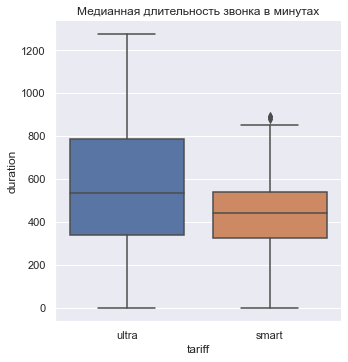

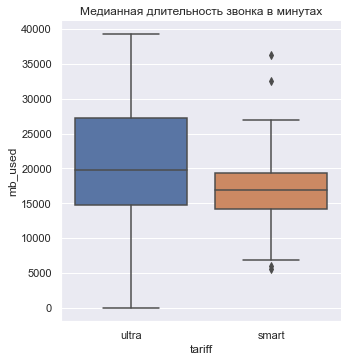

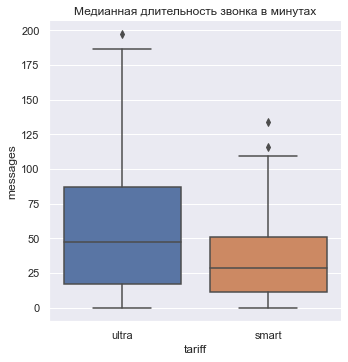

In [62]:
# построим графики по каждому тарифу
for column in ['duration', 'mb_used', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=medians, orient='v')
    plt.title('Медианная длительность звонка в минутах');

На графиках видно, что тариф «Ультра» имеет большую дисперсию, чем тариф «Смарт». Медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

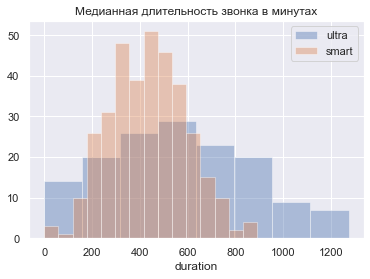

In [63]:
# построим гистограммы по каждому тарифу по продолжительности звонков
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['duration'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])
plt.title('Медианная длительность звонка в минутах');

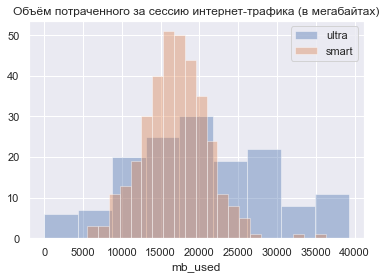

In [64]:
# построим гистограммы по каждому тарифу по количествам использованных мегабайт
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['mb_used'], kde=False)
_ = plt.legend(['ultra', 'smart'])
plt.title('Объём потраченного за сессию интернет-трафика (в мегабайтах)');

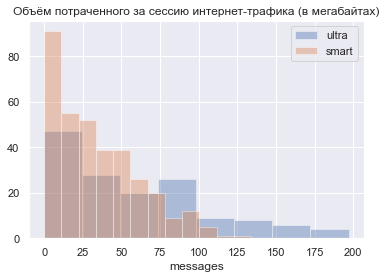

In [65]:
# построим гистограммы по каждому тарифу по количеству отправленных смс-сообщений
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['messages'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])
plt.title('Объём потраченного за сессию интернет-трафика (в мегабайтах)');

### Вывод

По графикам видно, что разброс значений тарифа «Смарт» меньше, чем у пользователей тарифа «Ультра» по всем показателям: по количеству использованных минут, количеству смс-сообщений и использованному интернет-трафику. 

Поведение пользователей тарифа «Ультра» более разнообразное. Пользователи дорогого тарифа более свободны в выборе того, как именно использовать объемы тарифного пакета: возможно, использование дорогого тарифа помогает им не думать о том, что в какой-то момент у них отключится интернет или закончится пакет по минутам разговора.

Так же заметно, что пользователи более дешёвого тарифа намного меньше отправляют смс-сообщений. Зачем тратить деньги, если есть интернет. 

Медианные значения пользователей тарифа «Смарт» приходятся как раз на те значения, которые ограничены тарифов. Поэтому после этого идёт уменьшение количества людей, которые пользуются услугами сверх тарифного пакета.

## Проверка гипотез

Проверим следующие гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Гипотеза №1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается 

**Сформулируем гипотезы:**

**H0**  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

**H1**  — средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [66]:
# проверим гипотезу
ultra = user_month.query('tariff == "ultra"')['income']
smart = user_month.query('tariff == "smart"')['income']

alpha = .05

results = st.ttest_ind(
    ultra, 
    smart)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.172655564462924e-190
Отвергаем нулевую гипотезу


In [67]:
# сгруппируем таблицу по медианному доходу и выбранному тарифу
user_month.pivot_table(index='tariff', values='income', aggfunc='median')

,income
tariff,
smart,959.898438
ultra,1950.000000


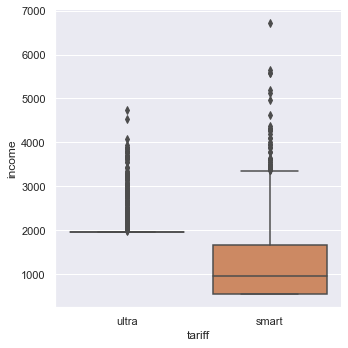

In [68]:
# построим графики для наглядности
_ = sns.catplot(x="tariff", y='income', kind="box", data=user_month, orient='v')

**Вывод:** 

Нулевая гипотеза была отвергнута - средняя выручка пользователей двух тарифов не равна. Следовательно, альтернативная гипотеза не была опровергнута - средняя выручка пользователей тарифов «Ультра» и «Смарт» на предоставленных данных различается.

Видно, что средние значения выручки по тарифам различаются, примерно в два раза. Это означает,  что пользователь тарифа «Смарт» с абонентской платой в 550 рублей скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета.

## Гипотеза №2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

**Сформулируем гипотезы:**

**H0**  — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

**H1** — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

In [69]:
# добавим наименование населенного пункта для каждого пользователя
for user in user_month.index:
    user_month.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

moscow = user_month.query('city == "Москва"')['income']
region = user_month.query('city != "Москва"')['income']

alpha = .05

results = st.ttest_ind(
    moscow, 
    region, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4549775646471024
Не получилось отвергнуть нулевую гипотезу


In [70]:
# напишем функцию для категоризации населённых пунктов на две категории столица - Москва и регионы 
def region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Регионы'
    
user_month['region'] = user_month['city'].apply(region)
user_month.pivot_table(index='region', values='income', aggfunc='median')

,income
region,
Москва,1704.632812
Регионы,1518.078125


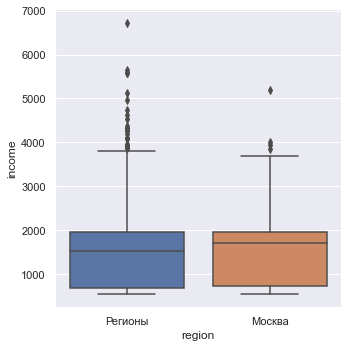

In [71]:
# построим график
_ = sns.catplot(x="region", y='income', kind="box", data=user_month, orient='v')

**Вывод:** 

Нулевая гипотеза не была отвергнута, так как средняя выручка пользователей Москвы и других городов равны на предоставленных данных не отличается, альтернативная гипотеза была отвергнута.

Цены на тарифы по всей стране одинаковые, почти каждый житель страны пользуется телефоном и услугами мобильных операторов, поэтому выручка компании «Мегалайн» от предоставленных услуг не зависит от региона, а скорее всего зависит от количество пользователей в этом регионе. Но это уже совсем другая гипотеза...

## Общий вывод

- Перед началом исследования нам была предоставлена небольшая выборка 500 пользователей компании «Мегалайн». Пользователи пользуются телефонной связью, смс-сообщениями, мобильным интернетом. Всего существует два тарифа - *«Ультра»* и *«Смарт»*, каждый имеет свои особенности, которые представлены в описании тарифов.

- Задачей исследования являлся анализ поведения клиентов, на основе которого можно сделать вывод — какой тариф лучше с целью скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. 

- Основная часть данных изначально была в хорошем состоянии. На этапе предобработки данных изменены только типы в столбцах с датами на datetime64, проверена корректность данных, наличие дубликатов.

- Была создана сводная таблица `user_month` - в которую сгруппировали данные по каждому клиенту за каждый месяц пользования. Рассчитали 4 столбца по месяцам года: количество использованных минут, отправленных смс-сообщений, объём использованного интернет-трафика и выручку за месяц - столбец **_income_**.

- В процессе анализа были выявлены следующие особенности использования предлагаемых тарифов:
1. **Звонки.** В тарифе *«Смарт»* подавляющее большинство абонентов укладываются в лимит 500 минут разговора (медианное значение за 2018 год - 440 минут), да и в тарифе *«Ультра»* не сильно ушли от этого значения - медианное значение 535 минут (обратим внимание, что лимит на тарифе - 3000 минут).
2. **Смс-сообщения.** Отправка смс-сообщений не сильно пользуется спросом. Абоненты тарифа *«Смарт»* вполне укладываются в лимит 50 смс-сообщений (медианное значение - 28 смс-сообщений в месяц), даже абоненты тарифа *«Ультра»* редко превышают порог в 50 смс-сообщений (медианное значение - 47 смс-сообщений в месяц). 
3. **Интернет** Абоненты тарифа *«Смарт»* любят посидеть в интернете и часто превышают лимиты в 15 Гб; медианный расход интернет-трафика на *«Смарт»* около 17 Гб. Медианный расход интернет-трафика не превышает порог в 30 Гб и составляет около 19 Гб в месяц. Большинство абонентов расходуют от 11 до 23 Гб интернет-трафика в месяц.
4. **Выручка.** Выручка от предоставления услуг абонента *«Ультра»* имеет медианное значение 1950 рублей. Можно сделать вывод, что они редко пользуются услугами сверх тарифного пакета. В то же время, абоненты тарифа *«Смарт»* очень часто платят сверх абонентской платы (медианное значение равно 960 рублей). 960 - 550 = 410 рублей. Такая переплата происходит в основном из-за того, что людям не хватает тарифных пакетор интернет-трафика. 

- В целом, многие абоненты тарифа *«Ультра»* могли бы перейти на тариф *«Смарт»* и платили бы меньше - если исходить из медианных  значений: 535 мин - 75 рублей переплаты. Трафик 19 Гб - примерно 800 рублей Итого получается 550 + 75 + 800 = 1425 рублей вместо 1950 рублей. При этом появляется больше гибкости, не все используют тарифный пакет в полном объёме. Поэтому тариф *«Смарт»* так и называется, людям дают базовые условия и дальше каждый может его подстроить под свои нужны. Такие вот умные технологии.

- В исследовании так же были проверены две гипотезы:
  1. Гипотеза № 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается: гипотеза не была опровергнута.
  2. Гипотеза № 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов: гипотеза не подтвердилась. На предоставленных данных различий не было выявлено. Нулевую гипотезу не удалось опровергнуть.


- По итогам исследования можно рекомендовать оператору продвигать тариф «Смарт». Такой тариф приносит больше прибыли (это очень весомый фактор для компании), абоненты «Смарт» часто переплачивают сверх лимита, в отличие от абонентов «Ультра», которые очень редко превышают свой лимит. Так же абонентская плата за тариф «Смарт» выглядит более привлекательно для абонентов. Не каждый готов платить 1950 рублей в месяц, а 550 рублей - вполне доступно и не так отпугивает. Но при всех преимуществах может наблюдаться и обратный эффект, пользователи могут разочароваться в том, что постоянно приходится переплачивать, что не хватает пакетов интернет-трафика и найти что-то более выгодное у компании-конкурента. Может возникнуть ситуация, что по тарифу *«Смарт»* не устраивает тарифный пакет, а по тарифу *«Ультра»* не устраивает цена.
- Дополнительно можно провести исследования, чтобы выявить, какой объём интернет-трафика будет комфортным и для компании, и для клиента. Чтобы не растерять свою базу и не остаться в убытках.
- Так же можно сократить количество смс-сообщений в тарифном плане, потому что пользователи не проявляют особую активность в их использовании.